In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,f1_score
from sklearn.metrics import roc_curve, auc


import joblib 

In [121]:
# Define the sheet name to read data from
sheet_name = 'vw_ChurnData'

# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_excel("prediction_data.xlsx", sheet_name=sheet_name)

# Display the first few rows of the fetched data
data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11340-JAM,Female,21,No,Jammu & Kashmir,8,7,NaN,Yes,No,...,Bank Withdrawal,19.950001,219.500000,0.0,0,78.599998,298.100006,Stayed,Others,Others
1,11348-MAH,Female,46,No,Maharashtra,11,19,Deal 3,Yes,No,...,Bank Withdrawal,56.049999,1522.650024,0.0,110,1235.079956,2867.729980,Stayed,Others,Others
2,11359-AND,Female,28,Yes,Andhra Pradesh,3,6,Deal 4,Yes,No,...,Credit Card,20.500000,290.549988,0.0,0,435.839996,726.390015,Stayed,Others,Others
3,11370-TAM,Female,21,No,Tamil Nadu,15,10,Deal 4,Yes,No,...,Credit Card,59.099998,772.849976,0.0,0,476.140015,1248.989990,Stayed,Others,Others
4,11392-JAM,Female,39,Yes,Jammu & Kashmir,11,1,Deal 2,Yes,No,...,Bank Withdrawal,84.400002,4484.049805,0.0,0,1655.640015,6139.689941,Stayed,Others,Others


In [122]:
data.describe()

,Age,Number_of_Referrals,Tenure_in_Months,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue
count,6007.000000,6007.000000,6007.00000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000
mean,47.289163,7.439820,17.39454,65.087598,2430.986173,2.038612,7.015149,797.283311,3233.246020
std,16.805110,4.622369,10.59292,31.067808,2267.481295,8.065520,25.405737,854.858840,2856.181081
min,18.000000,0.000000,1.00000,-10.000000,19.100000,0.000000,0.000000,0.000000,21.610001
25%,33.000000,3.000000,8.00000,35.950001,539.949982,0.000000,0.000000,107.084999,833.684998
50%,47.000000,7.000000,17.00000,71.099998,1556.849976,0.000000,0.000000,470.220001,2367.149902
75%,60.000000,11.000000,27.00000,90.449997,4013.900024,0.000000,0.000000,1269.839966,5105.685059
max,84.000000,15.000000,36.00000,118.750000,8684.799805,49.790001,150.000000,3564.719971,11979.339844


In [123]:
len(data)

6007

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  6007 non-null   object 
 1   Gender                       6007 non-null   object 
 2   Age                          6007 non-null   int64  
 3   Married                      6007 non-null   object 
 4   State                        6007 non-null   object 
 5   Number_of_Referrals          6007 non-null   int64  
 6   Tenure_in_Months             6007 non-null   int64  
 7   Value_Deal                   2710 non-null   object 
 8   Phone_Service                6007 non-null   object 
 9   Multiple_Lines               6007 non-null   object 
 10  Internet_Service             6007 non-null   object 
 11  Internet_Type                6007 non-null   object 
 12  Online_Security              6007 non-null   object 
 13  Online_Backup     

In [125]:
data['Customer_Status'].value_counts(normalize=True)


Customer_Status
Stayed     0.71167
Churned    0.28833
Name: proportion, dtype: float64

In [126]:
data.isnull().sum()


Customer_ID                       0
Gender                            0
Age                               0
Married                           0
State                             0
Number_of_Referrals               0
Tenure_in_Months                  0
Value_Deal                     3297
Phone_Service                     0
Multiple_Lines                    0
Internet_Service                  0
Internet_Type                     0
Online_Security                   0
Online_Backup                     0
Device_Protection_Plan            0
Premium_Support                   0
Streaming_TV                      0
Streaming_Movies                  0
Streaming_Music                   0
Unlimited_Data                    0
Contract                          0
Paperless_Billing                 0
Payment_Method                    0
Monthly_Charge                    0
Total_Charges                     0
Total_Refunds                     0
Total_Extra_Data_Charges          0
Total_Long_Distance_Charges 

In [127]:
data['Value_Deal'] = data['Value_Deal'].fillna('No Deal')


### Data Processing

In [128]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)


In [129]:
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y )

In [130]:
# For Random Forest, scaling isn't necessary, but it's good practice for a general pipeline.
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(),make_column_selector(dtype_include=['int64', 'float64'])),
        ("categoric", OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include="object"))
    ]
)

### Baseline Model

In [131]:
base_model =Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42))
    ])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_cv_scores = cross_val_score(
   base_model,X,y,
    cv=cv,
    scoring='roc_auc'
)

print(f"Logistic CV AUC:, {log_cv_scores.mean():.4f} +/- {log_cv_scores.std():.4f}")


Logistic CV AUC:, 0.8813 +/- 0.0092


In [132]:
base_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [133]:
print(base_model.named_steps['classifier'].classes_)


['Churned' 'Stayed']


In [134]:
y_pred_lr=base_model.predict(X_test)
y_prob_lr=base_model.predict_proba(X_test)[:, 0]

In [135]:
print("Accuracy score :",accuracy_score(y_test,y_pred_lr))
print("ROC_score :",roc_auc_score(y_test, y_prob_lr))
print("Confusion Matrix  :\n",confusion_matrix(y_test,y_pred_lr))

Accuracy score : 0.8144758735440932
ROC_score : 0.11092909988708563
Confusion Matrix  :
 [[292  55]
 [168 687]]


In [136]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

     Churned       0.63      0.84      0.72       347
      Stayed       0.93      0.80      0.86       855

    accuracy                           0.81      1202
   macro avg       0.78      0.82      0.79      1202
weighted avg       0.84      0.81      0.82      1202



### *Random Forest -->*

In [137]:
rf_model=Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("classifier",RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42)
    )])


rf_cv_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

print(f"Random Forest CV AUC:, {rf_cv_scores.mean():.4f} +/- {rf_cv_scores.std():.4f}")


Random Forest CV AUC:, 0.9028 +/- 0.0111


In [138]:
rf_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [139]:
print(rf_model.named_steps['classifier'].classes_)


['Churned' 'Stayed']


In [140]:
y_pred_rf=rf_model.predict(X_test)
y_prob_rf=rf_model.predict_proba(X_test)[:, 0]

In [141]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Confusion Matrix :\n",confusion_matrix(y_test,y_pred_rf))

Accuracy: 0.8402662229617305
ROC-AUC: 0.09196622680620858
Confusion Matrix :
 [[258  89]
 [103 752]]


In [142]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

     Churned       0.71      0.74      0.73       347
      Stayed       0.89      0.88      0.89       855

    accuracy                           0.84      1202
   macro avg       0.80      0.81      0.81      1202
weighted avg       0.84      0.84      0.84      1202



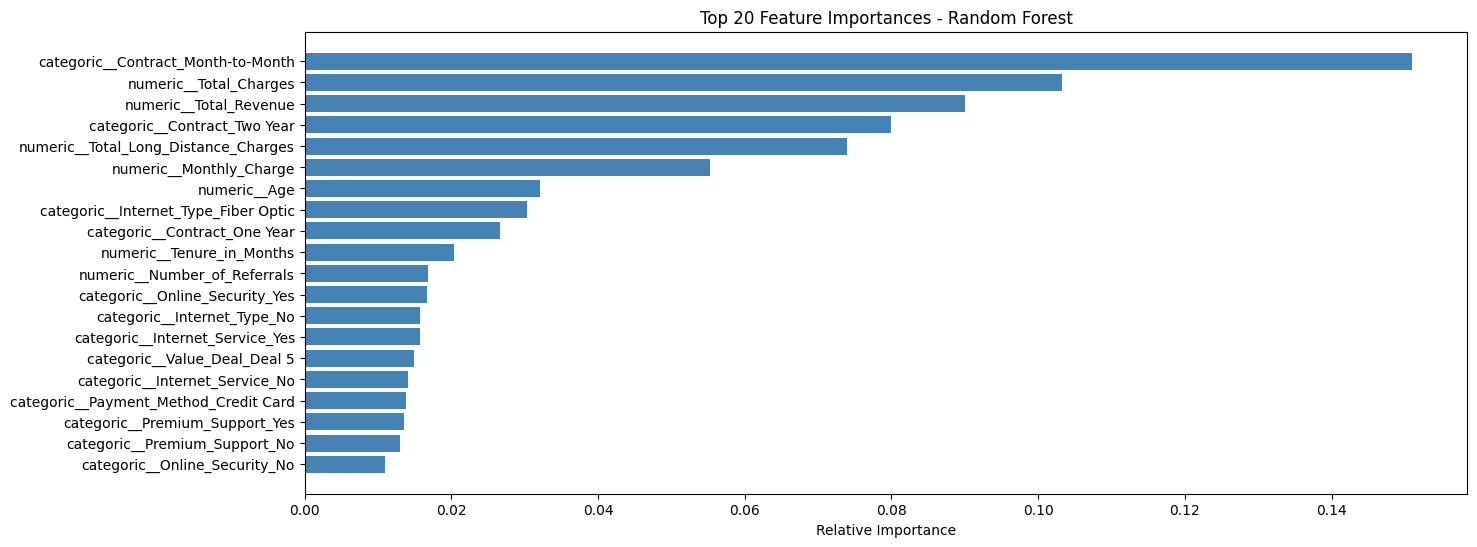

In [143]:
# Get feature names after preprocessing
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

# Get importances from RF
importances = rf_model.named_steps['classifier'].feature_importances_

# Sort them
indices = importances.argsort()[::-1]

plt.figure(figsize=(15, 6))

plt.barh(feature_names[indices][:20], importances[indices][:20],color='steelblue')
plt.gca().invert_yaxis()

plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Relative Importance")
plt.show()


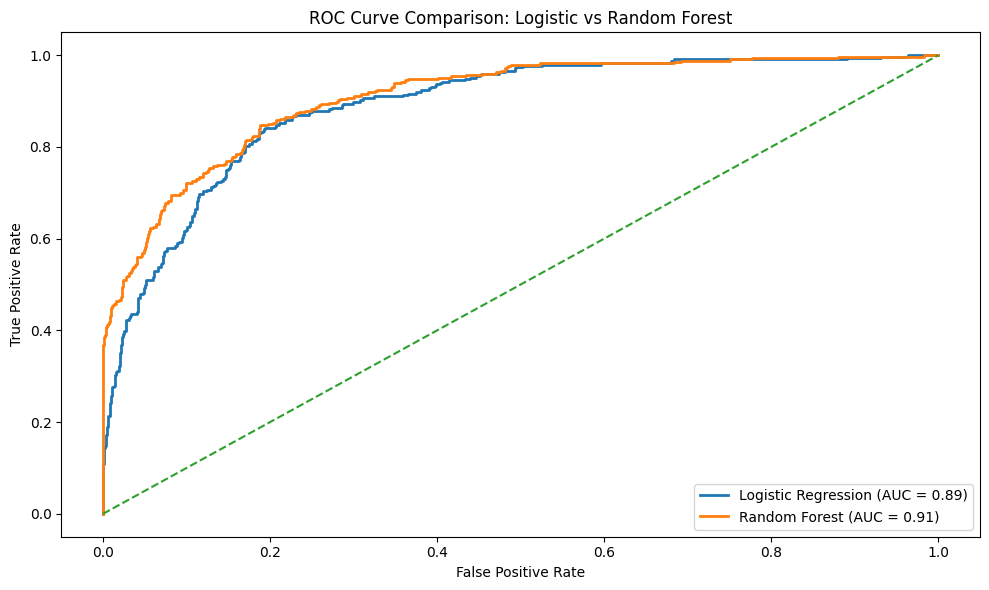

In [144]:
# Logistic ROC values
fpr_lr, tpr_lr,thresholds_lr = roc_curve(y_test, y_prob_lr, pos_label='Churned')
auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest ROC values
fpr_rf, tpr_rf,thresholds_rf = roc_curve(y_test, y_prob_rf, pos_label='Churned')
auc_rf = auc(fpr_rf, tpr_rf)

# Plot both on same graph
plt.figure(figsize=(10, 6))

plt.plot(fpr_lr, tpr_lr, lw=2,
         label=f'Logistic Regression (AUC = {auc_lr:.2f})')

plt.plot(fpr_rf, tpr_rf, lw=2,
         label=f'Random Forest (AUC = {auc_rf:.2f})')

# Random classifier diagonal
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic vs Random Forest')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [145]:
# Define the sheet name to read data from
sheet_name = 'vw_JoinData'

# Read the data from the specified sheet into a pandas DataFrame
new_data = pd.read_excel("prediction_data.xlsx", sheet_name=sheet_name)

# Display the first few rows of the fetched data
new_data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,12340-DEL,Female,51,Yes,Delhi,0,10,NaN,Yes,No,...,Credit Card,62.799999,62.799999,0.0,0,42.189999,104.989998,Joined,Others,Others
1,12469-AND,Male,24,Yes,Andhra Pradesh,11,4,NaN,Yes,No,...,Credit Card,55.299999,55.299999,0.0,0,36.689999,91.989998,Joined,Others,Others
2,15591-KAR,Female,26,No,Karnataka,3,31,NaN,Yes,No,...,Credit Card,20.400000,20.400000,0.0,0,45.910000,66.309998,Joined,Others,Others
3,15803-UTT,Female,34,No,Uttar Pradesh,6,31,NaN,Yes,No,...,Credit Card,19.150000,19.150000,0.0,0,22.370001,41.520000,Joined,Others,Others
4,16931-BIH,Female,39,Yes,Bihar,8,23,Deal 5,Yes,No,...,Credit Card,19.299999,19.299999,0.0,0,8.660000,27.959999,Joined,Others,Others


In [146]:
new_data['Value_Deal'] = new_data['Value_Deal'].fillna('No Deal')


In [147]:
# Keep original copy
original_data = new_data.copy()

In [148]:
# Drop columns not used for prediction
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 
                          'Churn_Category', 'Churn_Reason'], axis=1)

In [149]:
# Predict churn probability (1 = Churned)
churn_probs = rf_model.predict_proba(new_data)[:, 1]

# Add it to your dataframe
original_data['Churn_Probability'] = churn_probs

# Optionally, flag high-risk customers
original_data['High_Risk'] = original_data['Churn_Probability'] > 0.5

# Save predictions
original_data.to_csv("Churn_Predictions_Probabilities.csv", index=False)

In [150]:
# View only high-risk customers
high_risk_customers = original_data[original_data['High_Risk'] == True]

# Save to CSV if you want
high_risk_customers.to_csv("High_Risk_Joiners.csv", index=False)


In [151]:
# Total high-risk customers
high_risk_count = original_data['High_Risk'].sum()
print(f"Number of high-risk customers: {high_risk_count}")


Number of high-risk customers: 47


In [152]:
total_new = len(original_data)
high_risk_pct = (high_risk_count / total_new) * 100
print(f"Percentage of new joiners at high risk: {high_risk_pct:.2f}%")


Percentage of new joiners at high risk: 11.44%
